In [2]:
!pip install vaderSentiment

In [1]:
!pip install gensim

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
# from spacy import tokenizer # This line is commented out as it seems incorrect. spacy.tokenizer is not a standard module.
import re
# import nitk # This line is commented out as nitk is not a standard library. Did you mean nltk?
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Corrected import
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer # Corrected import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# on ajuste les parametres du plot
plt.rcParams["figure.figsize"] = (12, 8)
default_plot_colour= "#00bfbf"

In [5]:
data = pd.read_csv("fake_news_data.csv")
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


Text(0.5, 1.0, 'count of article classification')

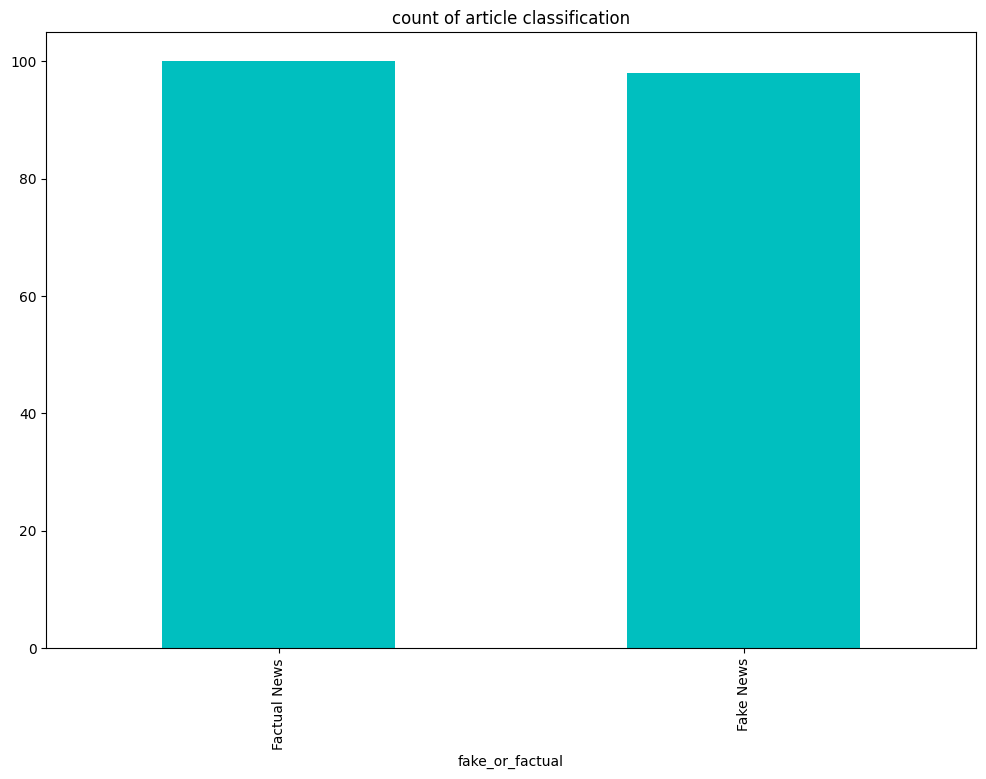

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title("count of article classification")

# POS tagging


In [7]:
# on commence par inialiser notre modèle spacy , puis nous référons au modèle qu'on veut utiliser , ici c'est en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [8]:
# nous allons créer notre ensemble de données , ensemble de fake news et de real news
fake_news = data[data['fake_or_factual'] == 'Fake News']
real_news = data[data['fake_or_factual'] == 'Factual News']


In [9]:
#on applique le spacy sur le texte de chaque ensemble de données
fake_spacydocs = list(nlp.pipe(fake_news['text']))  # nlp(jsbdjb) fait une tokenisation automatique
real_spacydocs = list(nlp.pipe(real_news['text']))

In [10]:
print(fake_spacydocs[0])

There are two small problems with your analogy Susan  Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim  refugees  to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis   a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly,  Sarandon wrote of her experience.  She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given

In [11]:
# on crée une fonction pour extraire les étiquettes de chaque ligne de notre dataframe
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text , i.ent_type_, i.pos_) for i in doc]
# pour chaque document texte on veut créer une liste avec [ le token , son type d'entité (NER) , sa fonction gramaticale pos]
#elle revoit un résulat sous forme [("Apple", "ORGanisation", "PROPN"), ("releases", "", "VERB"), ...]


traitements des documents fakes

In [12]:
# on crée une liste vide
fake_tagsdf = []
columns = ["token","ner_tag","pos_tag"]

In [13]:
# on parcoure chaque document dans la liste fake_spacydocs
# Si fake_spaceydocs = [doc1, doc2, doc3], tu les traites un par un.

fake_tagsdf = [] # Initialize as an empty list
for ix , doc in enumerate (fake_spacydocs):
#j'applique la fonction extract_token_tags que j'ai défini avant sur les doc de ma liste
   tags = extract_token_tags(doc)
# je transforme cette liste en un mini tableau (dataframe) , avec des colonnes claires
   tags = pd.DataFrame(tags)
   tags.columns=columns
   #j'ajoute ce mini tableau dans la liste fake_tagsdf
   fake_tagsdf.append(tags)

# je vais rassembler tous les minis tableau de chaque document dans gros dataframe
fake_tagsdf = pd.concat(fake_tagsdf)


############################

# passons au real news
fact_tagsdf = [] # Initialize as an empty list
for ix, doc in enumerate(real_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [14]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [15]:
# on compte la fréquence de chaque token dans les (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [16]:
# on compte la fréquence de chaque token dans les (facts)
# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [17]:
#je compte la fréquence des pos_tags dans le dataframe des fake news
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)


,token
pos_tag,
NOUN,2586
VERB,1817
PROPN,1672
ADJ,882
ADV,413
NUM,221
PRON,96
ADP,89
AUX,62


In [18]:
#je compte la fréquence des pos_tags dans le dataframe des real news
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)
#ascending=False on trie les valeurs du moins fréquents au plus fréquent tanazoli

,token
pos_tag,
NOUN,2179
VERB,1539
PROPN,1379
ADJ,747
ADV,263
NUM,205
PRON,79
ADP,70
AUX,43


In [19]:
# filtrons notre dataset pour prendre que le pos de la balise soit égale à noun , ça va afficher les 15 mots les plus fréquents
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'][:15]
# on affiche les premiers 15 mots les plus fréquent

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [20]:
pos_counts_fact[pos_counts_fact['pos_tag'] == 'NOUN'][:15]


,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


# Named Entities

In [21]:
# le but c'est extraire les entités nommées les plus présentes dans les fake news et real news

# on garde seulement les lignes où il ya des entités (entité non vide)
#fake_tagsdf[fake_tagsdf['ner_tag'] != ""]

#on combien de fois chaque mot - entité ('token','ner_tag') apparait , par exemple ("Trump" ,"person") : 15 , ("WHO", "ORG") : 10
#groupby(['token','ner_tag']).size()

# on trit pour afficher les entités les plus fréquentes en haut
# .sort_values(by='counts', ascending=False)

top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)


In [22]:
# top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [23]:
print(top_entities_fake.head(10))

        token ner_tag  counts
1730    Trump  PERSON     154
1729    Trump     ORG     152
2129      the     ORG     121
592   Clinton  PERSON     118
718    Donald  PERSON      75
890   Hillary  PERSON      64
1329    Obama  PERSON      59
1179   McCain  PERSON      53
2167     year    DATE      44
1662    Syria     GPE      42


In [24]:
print(top_entities_fact.head(10))

        token ner_tag  counts
1968      the     ORG     159
1633     U.S.     GPE     138
1373  Reuters     ORG     131
1615    Trump  PERSON     125
1614    Trump     ORG     124
882     House     ORG      67
1997     year    DATE      63
1646   United     GPE      59
1965      the     GPE      59
1254    Obama  PERSON      55


In [25]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

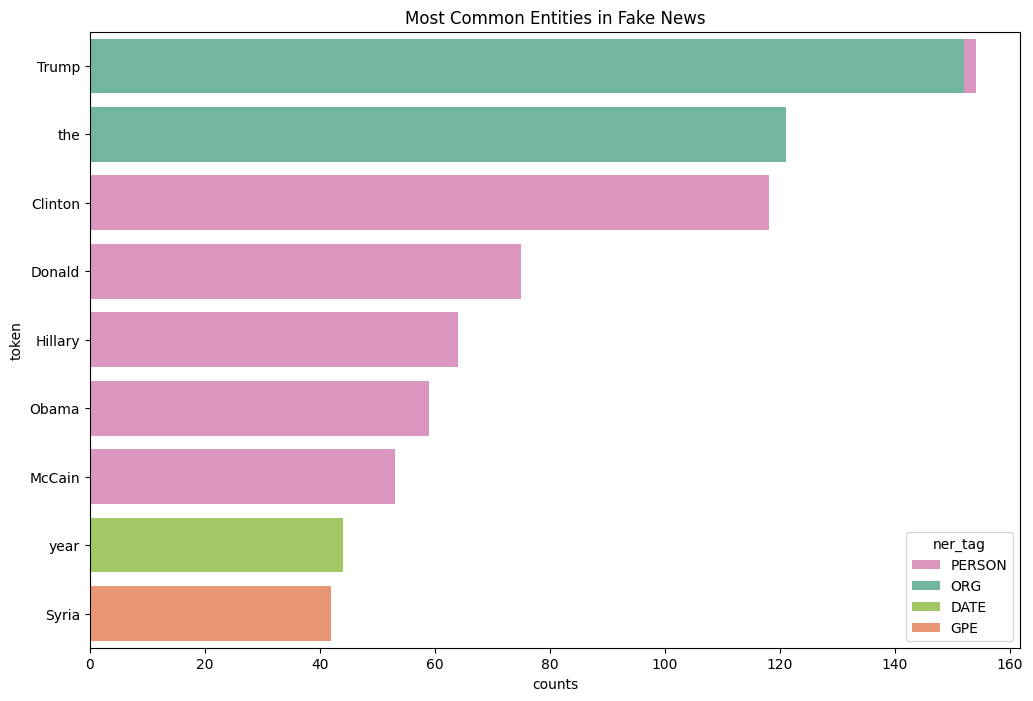

In [26]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

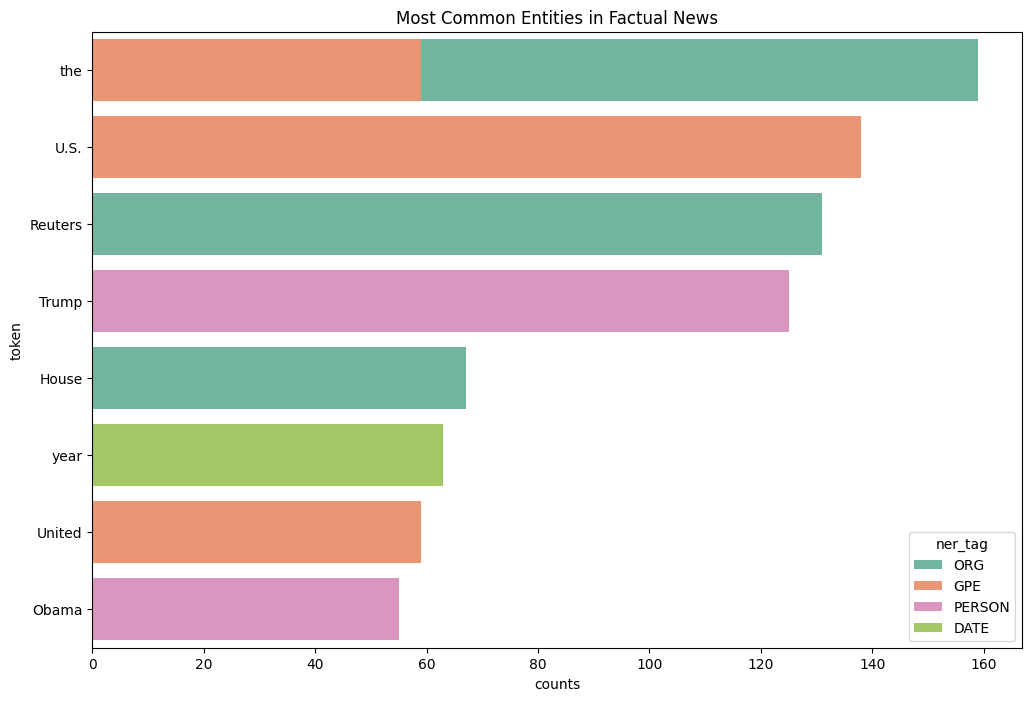

In [27]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

# Text Pre-processing

In [28]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [29]:
#  on veut netooyer text dans mon dataframe , en supprimant les débits de texte de type
#  "PARIS — Emmanuel Macron a annoncé..."   je veux supprimer paris
# "WASHINGTON — The president declared..."    //  //          washington
#  car cela polue le texte en traitement nlp
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)


In [30]:
# lowercase
data['text_clean'] = data['text_clean'].str.lower()


In [31]:
#remove ponctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)


In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
#stop words
stop_words = set(stopwords.words('english'))
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [36]:
# tokenize
data['text_clean'] = data.apply(lambda x : word_tokenize(x['text_clean']),axis=1)

In [41]:
#Lemmatize
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens : [lemmatizer.lemmatize(token) for token in tokens])


In [42]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [43]:
# most common unigrams after preprocessing
# cette ligne va combiner toute les listes de la colone text_clean en une seule grande liste
tokens_clean = sum(data['text_clean'], [])
# on créer des unigrames n = 1
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


/tmp/ipython-input-44-4013820514.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

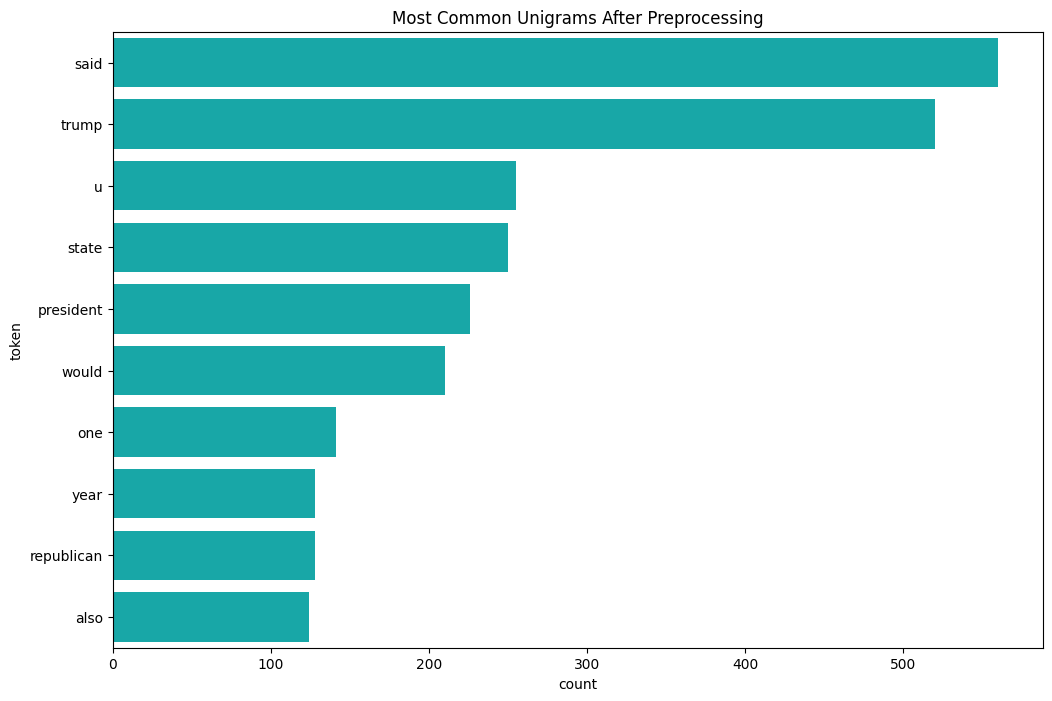

In [44]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count",
            y = "token",
            data=unigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [45]:
# most commen bigrams (n=2) after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


# SENTIMENT ANALYSIS

In [46]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [35]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [48]:
vader_sentiment = SentimentIntensityAnalyzer()

In [51]:

data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])
# .apply(lambda x: ...) cela applique la fonction vader_sentiment à chaque ligne de la colonne text
#  vader_sentiment.polarity_scores(x) : elle analyse le texte x et elle retourne undictionnaire de score de polarité (degré de sentiment)


In [53]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [54]:
#on va créer des labels pour classer les sentiments en posifts , négatifs et neutres
bins = [-1, -0.1, 0.1 , 1]
names = ['negative', 'neutral', 'positive'] # on définit les intervalles de -1 à -0.1 c'est négatif , de -0.1 à 0.1 c'est neutre et de 0.1 à 1 c'est positive
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)
# on crée une nouvelle colonne vader_sentiment_label où chaque score est placé dans une catégorie , grace à la fonction pd.cut() qui classe selon les intervalles bin

In [55]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


Text(0.5, 1.0, 'Sentiment Distribution')

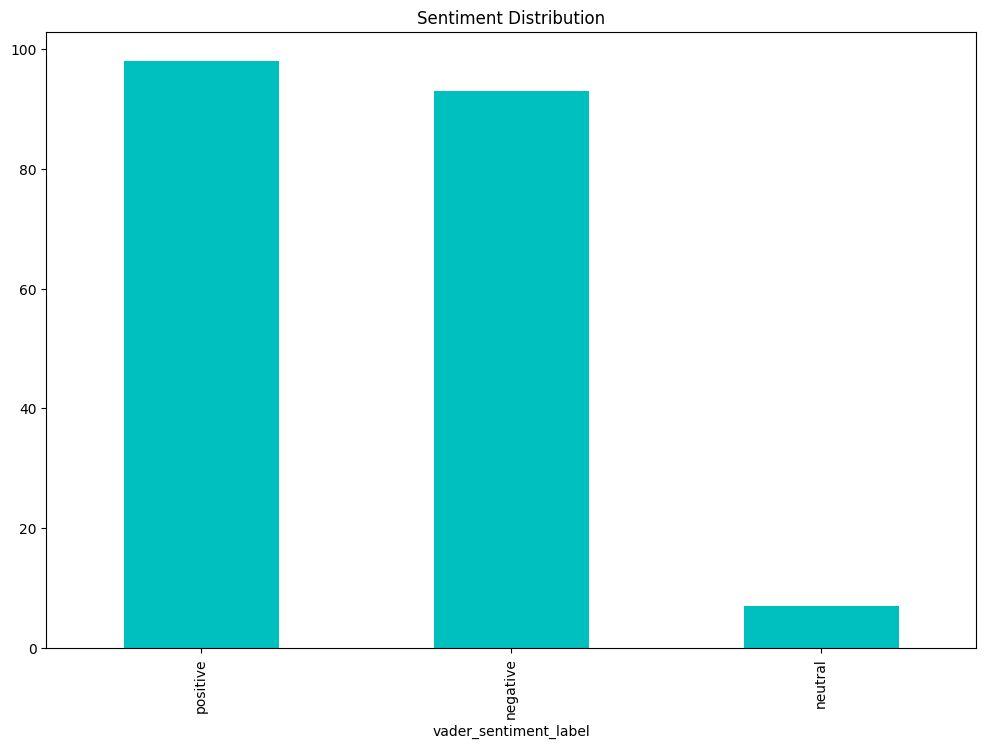

In [56]:
# on regarde golobalement combien de sentiments positif , negatifs , et neutres
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)
plt.title("Sentiment Distribution")

/tmp/ipython-input-57-392421043.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

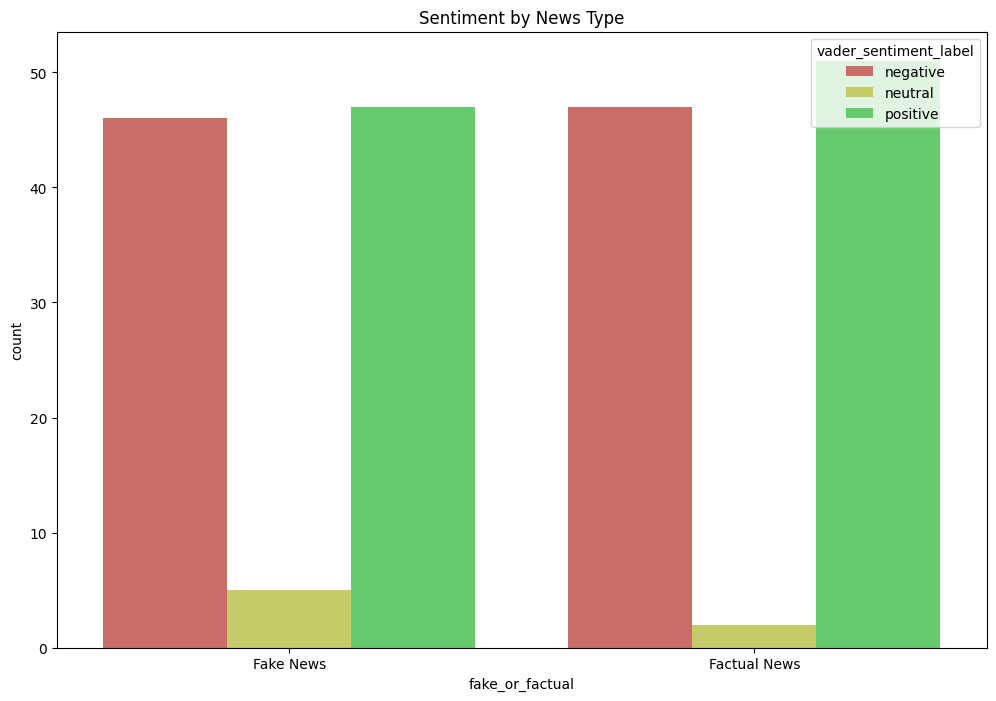

In [57]:
# on crée un graphique en barres pour visualiser la répartition des sentiments (posittifs,neutres,négatifs) selon le type de news (fake or factul)
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
) \
.set(title='Sentiment by News Type')

# Topic Modelling


### quelles sujets appraissent dans nos fake news


In [67]:
# on vectorise notre texte
# d'abord on selectionne seulement les textes de la colonne text_clean qui sont marqués comme fake news
fake_news_text=data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)
# vectorisons
dictionnary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionnary_fake.doc2bow(text) for text in fake_news_text]



> **on va tester plusieurs modèles LDA avec différents nombre de sujets puis mesurer leur qualité à l'aide d'un score de coherence(coherence score) , cela va m'aider à trouver le bon nombre de sujets : ni trop flou (peu de topics) , ni trop spécifique (trop de topics)**


In [102]:
coherence_values = [] # liste qui va contenir le score de coherence de chaque modele
model_list = [] # elle stocke tous les modèles LDA que je crée pour peut etre les réutiliser plus tard

In [103]:
# on définit la plage de topics à tester
min_topics = 2
max_topics = 11
# boucle pour tester plusieurs modèles LSA
for num_topics in range(min_topics, max_topics+1): # on teste chaque valeur de 2 à 11
    model = LsiModel(corpus=doc_term_fake, id2word=dictionnary_fake, num_topics=num_topics) # je crée un modele Lda et je lui donne les données vectorisées 'doc_term_fake'
    model_list.append(model)
    # on calcule le score de coherence
    coherencemodel = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionnary_fake, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


Topics: 2, Coherence: 0.39312779055721436
Topics: 3, Coherence: 0.469084314180587
Topics: 4, Coherence: 0.4331562546696516
Topics: 5, Coherence: 0.448026583693473
Topics: 6, Coherence: 0.3608903779886424
Topics: 7, Coherence: 0.5039692793277407
Topics: 8, Coherence: 0.39933890503501207
Topics: 9, Coherence: 0.3965223191985979
Topics: 10, Coherence: 0.38623621510263206
Topics: 11, Coherence: 0.38090308482233354


le meilleur nombre de sujets optimale pour mon modèle LDA c'est celui avec le score de coherence le plus élevé

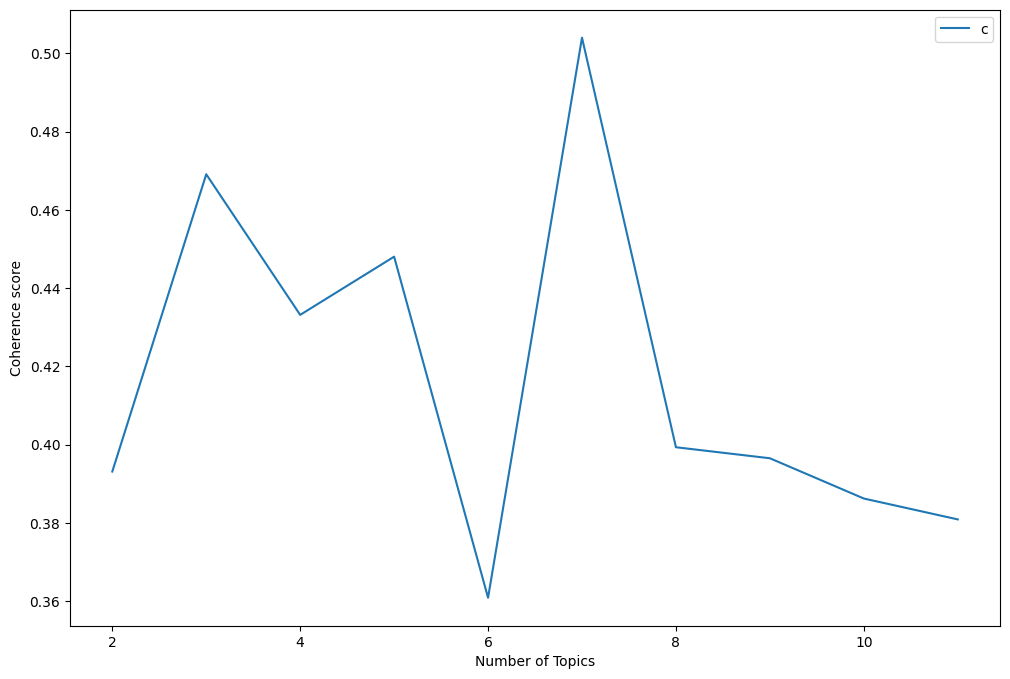

In [104]:
# visualitation du score de coherence en fonction de nombre de topics
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

alors 7 c'est le nombre idéal de sujet pour le modèle LDA car c'est elle avec le score de coherence le plus élevé

In [106]:
num_topics_lda = 7
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_fake, id2word=dictionnary_fake, num_topics=num_topics_lda,passes=10, iterations=100)

In [108]:
lda_model.print_topics(num_topics=num_topics_lda, num_words=10) # les 10 mots les plus courant pour chacun des thèmes

[(0,
  '0.010*"trump" + 0.009*"obama" + 0.008*"said" + 0.004*"state" + 0.004*"u" + 0.004*"also" + 0.004*"woman" + 0.003*"donald" + 0.003*"time" + 0.003*"go"'),
 (1,
  '0.016*"trump" + 0.006*"would" + 0.005*"flynn" + 0.005*"one" + 0.004*"test" + 0.004*"november" + 0.004*"8" + 0.004*"donald" + 0.004*"said" + 0.004*"boiler"'),
 (2,
  '0.009*"president" + 0.008*"republican" + 0.007*"party" + 0.006*"clinton" + 0.005*"year" + 0.005*"trump" + 0.005*"woman" + 0.005*"would" + 0.004*"state" + 0.004*"court"'),
 (3,
  '0.010*"student" + 0.008*"trump" + 0.006*"state" + 0.006*"tobacco" + 0.005*"campus" + 0.005*"law" + 0.004*"said" + 0.004*"ordinance" + 0.003*"white" + 0.003*"career"'),
 (4,
  '0.010*"trump" + 0.008*"clinton" + 0.006*"time" + 0.006*"food" + 0.005*"stamp" + 0.005*"said" + 0.005*"million" + 0.004*"president" + 0.004*"hillary" + 0.004*"rich"'),
 (5,
  '0.006*"would" + 0.006*"state" + 0.006*"trump" + 0.006*"email" + 0.005*"said" + 0.005*"official" + 0.005*"law" + 0.005*"clinton" + 0.004*

# TF-IDF et LSA

In [109]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True) # création du modèle TF-IDF
    corpus_tfidf = tfidf[doc_term_matrix] # application sur les documents
    return corpus_tfidf

In [112]:
# fonction qui teste plusieurs nombres de topics ( de min_topics à max_topics) et qui calcue leur score de cohérence
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v') # on calcule la coherence avec ce modèle c_v
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

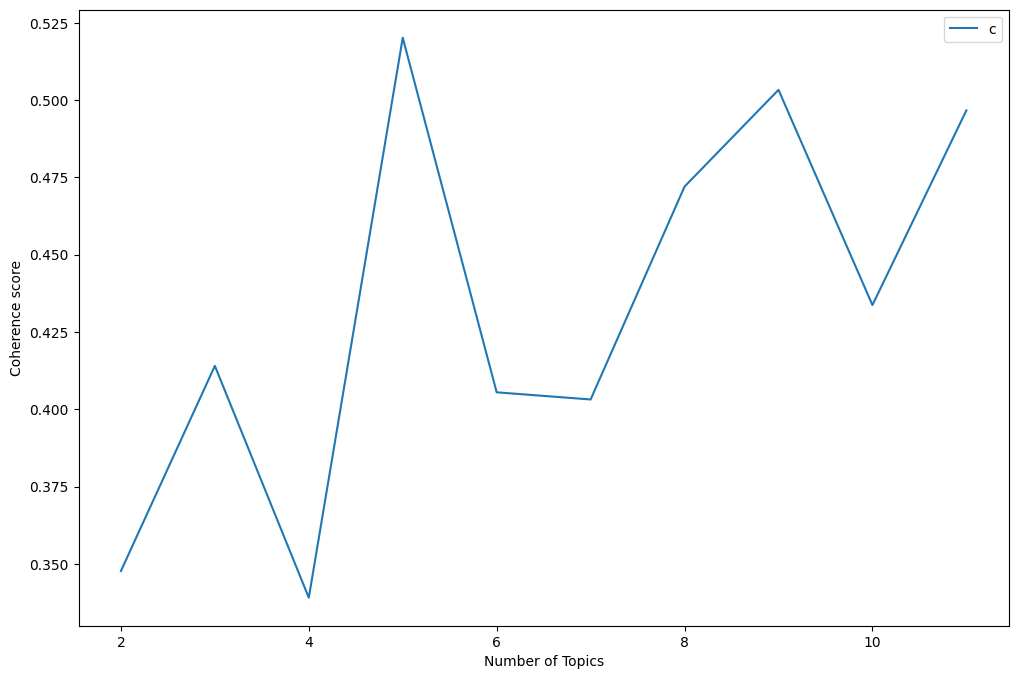

In [113]:
#on  applique la fonction tf-idf qu'on a définit pour transformer mon corpus doc_term_fake (qui est en bag of words) à la forme pondérée TF-IDF
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

# on applique la fonction get_coherence_scores
get_coherence_scores(corpus_tfidf_fake, dictionnary_fake, fake_news_text, 2, 11)

on applique le modèle de LSA for fake_news data avec nombre de topic égal à 5 car c'est celui avec le plus grand nombre de coherence

In [114]:
lsa_fake = LsiModel(corpus=corpus_tfidf_fake, id2word=dictionnary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"savant" + 0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

# predict fake or factual news

In [115]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [120]:
# data['text_clean' contient des tokens , mais un modèle de machine learning attend  du texte , pas des listes
# on va parcourir les listes de mots dans text_clean
# map(str,1) on transforme chaque mot de la liste en string (au cas où il ne l'est pas déjà)
# ',' on colle tous les mots ensemble avec une virgule entre eux
# par exemple  : Si text_clean[0] = ['messi', 'but', 'match'], alors :
#X[0]="messi,but,match"

X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']


In [121]:
# on vectorise le texte en utilisant bag of words
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [122]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [124]:
# logistic regression pour faire la classification
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [125]:
accuracy_score(y_pred_lr, y_test)


0.9333333333333333

In [126]:
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

Factual News       1.00      0.86      0.93        29
   Fake News       0.89      1.00      0.94        31

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [127]:
svm = SGDClassifier().fit(X_train, y_train)


In [128]:
y_pred_svm = svm.predict(X_test)


In [129]:
accuracy_score(y_pred_svm, y_test)


0.8333333333333334

In [130]:
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

Factual News       0.83      0.83      0.83        29
   Fake News       0.84      0.84      0.84        31

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

